In [2]:
print('ready')

ready


In [4]:
import torch as t
from torch.nn import ReLU, SELU, LeakyReLU
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from IPython import display
from parse_dataset import *
from icnn import ICNNBN, gradient_step_action, diff_params, loss_beyond_RMAX
from copy import deepcopy
from utils import variable

# Load and parse dataset

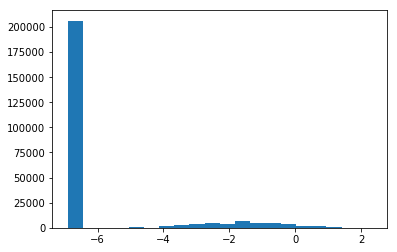

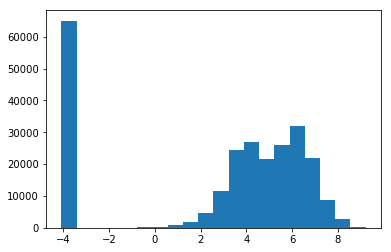

In [5]:
data = pd.read_csv('Sepsis_imp.csv')
replace_absurd_temperatures(data)
data = drop_patients_with_absurd_weights(data)
data = drop_patients_with_unrealistic_HR_or_BP(data)
data = add_relative_time_column(data)
data = drop_patient_with_negative_input(data)
add_small_quantities(data)
create_action_column(data)
add_log_actions(data)

log_scaler = StandardScaler()
scaler = StandardScaler()
action_scaler = StandardScaler()
train_idx, test_idx = split_train_test_idx(data)

# scale on train data only
scaler.fit(data.loc[data.icustayid.isin(train_idx)][numerical_columns_not_to_be_logged])
log_scaler.fit(np.log(data.loc[data.icustayid.isin(train_idx)][numerical_columns_to_be_logged]))
action_scaler.fit(data.loc[data.icustayid.isin(train_idx)][log_action_cols])

plt.hist(data.log_vaso, bins=20)
plt.show()
plt.hist(data.log_fluid, bins=20)
plt.show()

Split train/test

In [6]:
train_idx, test_idx = split_train_test_idx(data)

List of transitions `(s,a,r,s')`

In [7]:
# transitions_train = transition_iterator(data, test_idx, scaler, log_scaler, action_scaler, RMAX=15, log_action=True)
transitions_train = transition_iterator(data, train_idx, scaler, log_scaler, action_scaler, RMAX=15, log_action=True)

In [8]:
transitions_dict = {k: {
    's': values[0],
    'a': values[1],
    'r': values[2],
    's\'': values[3]   
}
 for k, values in enumerate(transitions_train)
}

Compute bounds for the actions (you don't have right to prescribe less than the min or more than the max). It gives bounds to the possible actions and ensure that the max of Q can actually be found

In [9]:
min0 = min([d['a'][0] for k, d in transitions_dict.items()])
max0 = max([d['a'][0] for k, d in transitions_dict.items()])
min1 = min([d['a'][1] for k, d in transitions_dict.items()])
max1 = max([d['a'][1] for k, d in transitions_dict.items()])

# Test maximisation de Q

Ce bout de code est celui qui est au debut de `get_q_target`

In [11]:
icnn = ICNNBN(2,200,50,activation=LeakyReLU(.01))

In [12]:
next_state = t.cat([
    variable(np.array([50*[np.nan]])),
    variable(np.random.normal(size=(1,50)))
]).float()

from time import time
t0 = time()
next_state_ = []
good = dict()
for i, s in enumerate(next_state):
    if np.sum(np.isnan(s.data.numpy()))==0:
        next_state_.append(s.resize(1, 50))
        good[i] = len(good)
if len(good) == 0:
    print('no good', rewards.squeeze())
else:
    next_state_ = t.cat(next_state_)
    max_action = variable(np.zeros((len(next_state_), 2)), requires_grad=True).float()
    prev_action = variable(np.zeros((len(next_state_), 2)), requires_grad=True).float()
    input_param = t.nn.Parameter(max_action.data)
    optimizer_for_a = t.optim.Rprop([input_param], lr=5e-1)
    for k in range(7):
        max_action, input_param, optimizer_for_a = gradient_step_action(icnn, next_state_, max_action, min0, max0, min1, max1, input_param=input_param, optimizer=optimizer_for_a)
        if np.max(np.abs(prev_action.data.numpy() - max_action.data.numpy())) < 1e-5:
            break
print(time()-t0)

0.01581287384033203


In [13]:
max_action

Variable containing:
 0  0
[torch.FloatTensor of size 1x2]

In [14]:
min0, min1, max0, max1

(-0.44044644924062354,
 -1.6014361525447329,
 4.0414326568511685,
 1.5351429620772477)

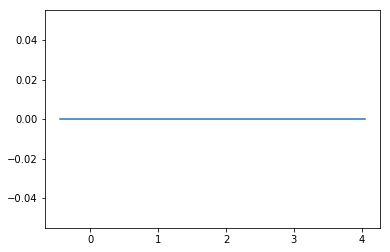

In [15]:
actions = variable(np.array([[a,0.] for a in np.arange(min0,max0,1e-2)])).float()
Qvalues = icnn.forward(next_state_, actions).data.numpy()
plt.plot(np.arange(min0,max0,1e-2),Qvalues)
plt.show()

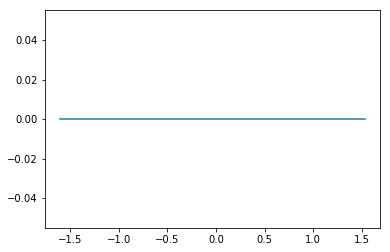

In [16]:
actions = variable(np.array([[-.52,a] for a in np.arange(min1,max1,1e-2)])).float()
Qvalues = icnn.forward(next_state_, actions).data.numpy()
plt.plot(np.arange(min1,max1,1e-2),Qvalues)
plt.show()

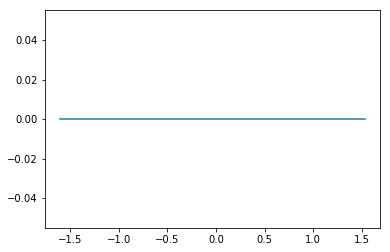

In [17]:
actions = variable(np.array([[0.,a] for a in np.arange(min1,max1,1e-2)])).float()
Qvalues = icnn.forward(next_state_, actions).data.numpy()
plt.plot(np.arange(min1,max1,1e-2), Qvalues)
plt.show()

# test get_q_target

In [96]:
Q_select = ICNN(3,50)
from copy import deepcopy
Q_eval = deepcopy(Q_target)

In [97]:
s = []
a = []
r = []
s_ = []
for i in range(20):
    s.append(variable(transitions_dict[i]['s'].reshape((1,-1))))
    a.append(variable(transitions_dict[i]['a'].reshape((1,-1))))
    r.append(variable(transitions_dict[i]['r'].reshape((1,-1))))
    s_.append(variable(transitions_dict[i]['s\''].reshape((1,-1))) if transitions_dict[i]['s\''] is not None else variable(np.array(50*[np.nan]).reshape((1,-1))))
s = t.cat(s)
a = t.cat(a)
r = t.cat(r)
s_ = t.cat(s_)

In [106]:
s_

Variable containing:
 1.3395 -1.8131  0.4918  ...   0.0000  0.0000  0.0000
 1.3395 -1.8131  0.2042  ...   0.0000  0.0000  0.0000
 1.3395 -1.8131 -0.0834  ...   0.0000  0.0000  0.0000
          ...             ⋱             ...          
    nan     nan     nan  ...      nan     nan     nan
-0.5504 -0.8776 -0.6587  ...   1.0000  0.0000  0.0000
-0.5504 -0.8776 -0.6587  ...   1.0000  0.0000  0.0000
[torch.FloatTensor of size 20x50]

In [105]:
max_steps_a = 10
gamma = 0.98
next_state_ = []
good = dict()
for i, s in enumerate(s_):
    if not np.isnan(s.data.numpy()[0]):
        next_state_.append(s.resize(1, 50))
        good[i] = len(good)
if len(good) == 0:
    raise Exception
else:
    next_state_ = t.cat(next_state_)
    max_action = variable(np.zeros((len(next_state_), 2)), requires_grad=True).float()
    prev_action = variable(np.zeros((len(next_state_), 2)), requires_grad=True).float()
    input_param = t.nn.Parameter(max_action.data)
    optimizer_for_a = t.optim.Rprop([input_param], lr=5e-1)
    for k in range(max_steps_a):
        max_action, input_param, optimizer_for_a = gradient_step_action(Q_select, next_state_, max_action, min0, max0, min1, max1, input_param=input_param, optimizer=optimizer_for_a)
        if np.max(np.abs(prev_action.data.numpy() - max_action.data.numpy())) < 1e-3:
            break
        prev_action = max_action * 1
    
    print(good)
    pred = Q_eval.forward(next_state_, max_action)
    Qvalues = [pred[good[i]].float().resize(1, 1) if i in good else variable(np.zeros((1, 1))).float() for i in range(len(s_))]
    max_prev_Q_value = t.cat(Qvalues, dim=0)
    Q_target = r.squeeze() + gamma * max_prev_Q_value.squeeze()


{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 10, 11: 11, 12: 12, 14: 13, 15: 14, 16: 15, 18: 16, 19: 17}


In [107]:
r

Variable containing:
    0
    0
    0
    0
    0
    0
    0
    0
    0
    0
    0
    0
    0
   15
    0
    0
    0
    0
    0
    0
[torch.FloatTensor of size 20x1]

In [ ]:
actions = variable(np.array([[0.,a] for a in np.arange(min1,max1,1e-2)])).float()
Qvalues = Q_select.forward(next_state_, actions).data.numpy()
plt.plot(np.arange(min1,max1,1e-2), Qvalues)
plt.show()